In [1]:
from tqdm.notebook import tqdm
import os
from glob import glob
import json
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Union

import albumentations as A
from multiprocessing.pool import ThreadPool
import cv2
import numpy as np
import torch
from torch import nn 
from torchvision.ops import DeformConv2d 
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

import pycocotools.coco as coco
from pycocotools.cocoeval import COCOeval

In [21]:
class Baseset(Dataset):

    def __init__(self, folders: List[str], h: int, w: int, cache=False,
        transform=None, undistort=False):
        super().__init__()
        self.folders = folders  # e.g. ['data/F0', ...]
        self.h = h  # image height
        self.w = w  # image width 
        self.transform = transform

        self.data = self.extract_data(folders)
        self.size = len(self.data)
        if cache:
            if undistort:
                cam_params = self.load_cam_params()
                self.cache_images(cam_params)
            else:
                self.cache_images()

    def cache_images(self, cam_params=None):
        if cam_params is None:
            imread = self.imread
        else:
            imread = lambda images: self.imread(images, **cam_params)
        results = ThreadPool(4).imap(imread, (lane['images'] for lane in self.data))
        pbar = tqdm(enumerate(results), total=self.size)
        gb = 0
        for lane_nr, lane_images in pbar:
            self.data[lane_nr]['images'] = lane_images  
            gb += lane_images.nbytes
            pbar.desc = f'Caching images ({gb/1E9:.1f}GB)'

    @staticmethod
    def extract_data(folders: List[str]):
        '''
        extract the relevant information from the folder structure and 
        cluster it lane-wise:

        [{'images': [('.../some_name.tiff', ...], 
          'poses': [pose_M3x4, ...],
          'annotated_image': integer_index, 
          'polys': [[...]], }, 
         {...}, ...]
        
        note: for each image there exists a pose, per lane there are bbox 
        annotations for a single image (bboxes make sense after integration)
        ''' 
        data = []  # each lane is a element (dictionary) in the 'data' list
        for folder_path in folders:
            pose_files = sorted(glob(os.path.join(folder_path, 'Poses', '*.json')))
            label_files = sorted(glob(os.path.join(folder_path, 'Labels', '*.json')))
            for pose_file, label_file in zip(pose_files, label_files):
                lane = {}
                poses = json.load(open(pose_file, 'rb'))['images']
                labels = json.load(open(label_file, 'rb'))['Labels']
                lane_nr = os.path.splitext(os.path.basename(pose_file))[0]
                base_path = os.path.join(folder_path, 'Images', lane_nr)

                image_paths = []
                pose_matrices = []
                for pose in poses:
                    image_paths.append(os.path.join(base_path, pose['imagefile']))
                    pose_matrices.append(np.asarray(pose['M3x4']))

                polys = []
                if isinstance(labels, list) and len(labels):  
                    for label in labels:
                        polys.append(label['poly'])
                    # each lane has a single annotated image (the integral image)
                    lane['annotated_image'] = image_paths.index(os.path.join(base_path, 
                        labels[0]['imagefile']))  
                    # polygons: [ [[x1, y1], ...next point], ...next polygon ]
                    lane['polys'] = polys
                else:  # otherwise empty => no annotations (no humans)
                    lane['annotated_image'] = lane['polys'] = None

                # we have the camera extrinsics for each image in the lane
                lane['images'] = image_paths
                lane['poses'] = pose_matrices

                data.append(lane)  # each pose and label file correspondes to a lane
                
        return data

    @staticmethod
    def show_images(images: np.ndarray, mask: np.ndarray = None, figsize=None):
        fig = plt.figure(figsize=figsize)
        if mask is not None:  # k,
            images = images[mask, ...]  # k x h x w
        images = torch.as_tensor(images).unsqueeze(1)  # n(k) x 1 x h x w
        grid = make_grid(images, nrow=int(np.sqrt(images.size(0))))  # 3 x h x w
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.show()

    @staticmethod
    def show_image(image: np.ndarray, cmap: str = 'gray', figsize=None):
        fig = plt.figure(figsize=figsize)
        plt.imshow(image, cmap=cmap)
        plt.axis('off')
        plt.show()

    @staticmethod
    def load_cam_params(param_folder: str = 'calibration/parameters'):
        ''' Camera intrinsics K and distortion coefficients. '''
        K = np.load(os.path.join(param_folder, 'K.npy'))
        dist = np.load(os.path.join(param_folder, 'dist_coeffs.npy'))
        # return cam params as dictionary
        return {'K': K, 'dist': dist}

    @staticmethod
    def imread(paths: List[str], K=None, dist=None) -> np.ndarray:
        images = []
        for path in paths:
            image = cv2.imread(path, cv2.IMREAD_ANYDEPTH)  # 16 bit image
            image = cv2.normalize(image, dst=None, alpha=0, beta=2**16 - 1, 
                norm_type=cv2.NORM_MINMAX)
            image = (image >> 8).astype(np.uint8)  # 8 bit image
            
            if K is not None and dist is not None:  # undistort images
                h, w = image.shape
                # new camera intrinsics based on free scaling parameter
                new_K, roi = cv2.getOptimalNewCameraMatrix(K, dist, 
                    (w, h), 1, (w, h))

                # undistort v1
                # mapx, mapy = cv2.initUndistortRectifyMap(K, dist, None, new_K, (w, h), 5)
                # image = cv2.remap(image, mapx, mapy, cv2.INTER_LINEAR)

                # undistort v2
                image = cv2.undistort(image, K, dist, None, new_K)

                # crop
                x, y, w, h = roi 
                image = image[y:y+h, x:x+w]
                
            
            images.append(image)

        return np.asarray(images)  # n_paths x h x w

    @staticmethod
    def integrate(images: Union[List[str], np.ndarray], pose_matrices: List[np.ndarray], 
        K: np.ndarray, z: float = 30.0, idc: int = None, verbose=False) -> Tuple[np.ndarray, np.ndarray]:
        '''
        integral :=
        a mapping of a image sequence under perspective to another image view

        images contains the image file paths or the np.ndarray images and pose_matrices 
        the M3x4 matrices where M3x4 = (R3x3, t3x1) => thus without intrinsics K

        z is the height of the camera (drone) in meters (units must be the same
        as used when calculating the extrinsics)
        '''
        sequence_len = len(images)

        if idc is None:  # otherwise given and must not be at the center
            idc = sequence_len // 2  # index of center image = center of images (if odd length)
        
        if isinstance(images, list):  # otherwise np.ndarray => already images
            images = Baseset.imread(images)  # 8 bit images from path
        
        h, w = images.shape[1:]  # gray scale images
        integral = np.zeros((h, w), np.float64)
        
        # inverse of the intrinsic mapping
        K_inv = np.linalg.inv(K)

        Mc = pose_matrices[idc]
        Rc = Mc[:, :3]  # 3 x 3
        tc = Mc[:, 3:]  # 3 x 1

        for idx in range(sequence_len):
            if idx != idc:
                Mr = pose_matrices[idx]  # 3 x 4
                Rr = Mr[:, :3]  # 3 x 3
                tr = Mr[:, 3:]  # 3 x 1

                # relative translation and rotation
                R_rel = Rc @ Rr.T  # 3 x 3
                t_rel = tc - R_rel @ tr  # 3 x 1

                B = K @ R_rel @ K_inv
                B[:, 2:] += K @ t_rel / z
                # borderMode=cv2.BORDER_REPLICATE
                warped = cv2.warpPerspective(images[idx], B, (w, h),
                    borderMode=cv2.BORDER_CONSTANT, 
                    borderValue=np.mean(images))

                if verbose:
                    Baseset.show_image(warped)

                integral += warped
            else:
                if verbose:
                    Baseset.show_image(images[idx])

                integral += images[idx]

        integral /= sequence_len
        # 8 bit gray scale integral image
        integral = cv2.normalize(integral, None, 
            0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # returns (image sequence, integral image)
        return images, integral  

    def __len__(self):
        return self.size

    def _float(self, x: float):
        return float(f'{x:0.2f}')


class IntegralDataset(Baseset):
    ''' For training and testing of the deep learning based integration. '''

    def __init__(self, folders: List[str], h: int, w: int, sequence_len=5,
        cache=False, transform=None, undistort=False, random_select=True):
        super().__init__(folders, h, w, cache, transform, undistort)
        self.sequence_len = sequence_len
        cam_params = self.load_cam_params()
        self.K = cam_params['K']
        self.random_select = random_select

    def __getitem__(self, idx):
        lane = self.data[idx]  # select lane

        if self.random_select:  # randomly select adjacent images and correspondig poses 
            start = np.random.randint(len(lane['images']) - self.sequence_len)
        else:  # choose annotated image as center
            start = lane['annotated_image'] - self.sequence_len // 2
        images = lane['images'][start:start + self.sequence_len]
        pose_matrices = lane['poses'][start:start + self.sequence_len]
        image_sequence, integral_image = self.integrate(images, pose_matrices, self.K)

        if self.transform is not None:
            # data augmentation on images
            image_sequence, integral_image = self.transform(image_sequence, integral_image)
        
        return image_sequence, integral_image

In [22]:
# test the implementation of the integration dataset:
folders = [f'data/F{i}' for i in range(12)]
h, w = 512, 640
ids = IntegralDataset(folders, h, w, sequence_len=5, cache=True, transform=None, undistort=True, random_select=False)

### trying different loss functions to penalize wrong integration
note: not trivial since integral image is mostly composed of center view

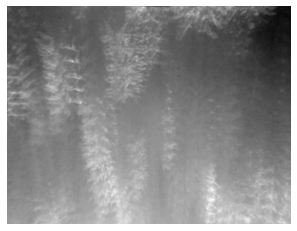

In [26]:
def MSE(xhat: np.ndarray, x: np.ndarray):
    return np.mean(np.square(x - xhat)).item()


image_sequence, integral_image = ids[0]
simple_add = np.mean(image_sequence, axis=0)  # add without perspective
ids.show_image(simple_add)

In [27]:
MSE(integral_image, simple_add)

1045.0618477862035

In [28]:
MSE(integral_image, integral_image)

0.0

In [29]:
center_image = image_sequence[len(image_sequence) // 2]
MSE(integral_image, center_image)

110.50950189579257

In [31]:
for i, image in enumerate(image_sequence):
    print(i, ': MSE =', MSE(integral_image, image))

0 : MSE = 106.67914475293541
1 : MSE = 106.54353443003914
2 : MSE = 110.50950189579257
3 : MSE = 108.36260472725048
4 : MSE = 111.21079607999022


In [32]:
# thus it is most likely that the identity function is learnt choosing an image randomly!

### tried different undistort ways and fill values for perspective transform

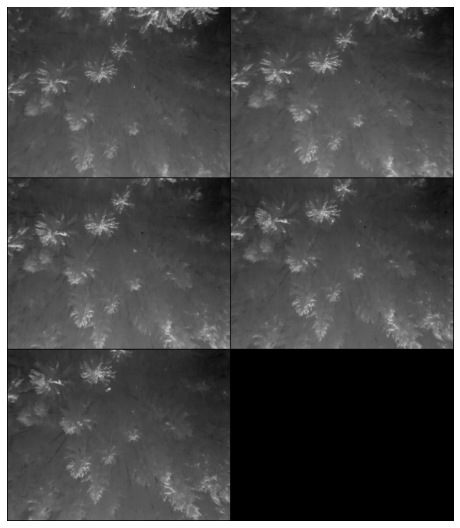

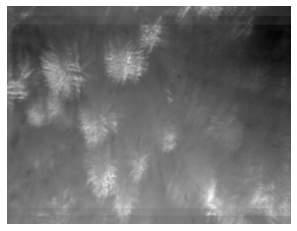

In [23]:
# integrate with undistorted images
#
# borderMode=cv2.BORDER_CONSTANT, 
# borderValue=np.mean(images)
#
image_sequence, integral_image = ids[0]
ids.show_images(image_sequence, figsize=(8, 10))
ids.show_image(integral_image)

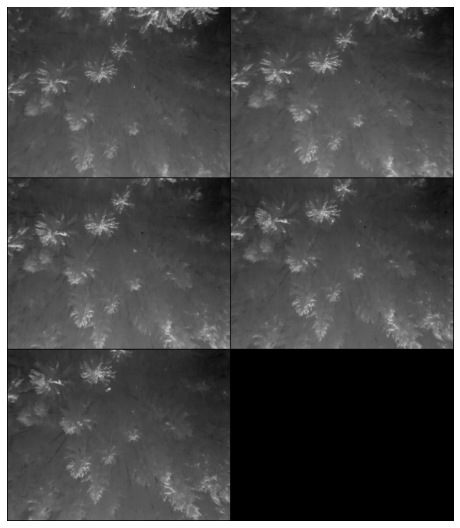

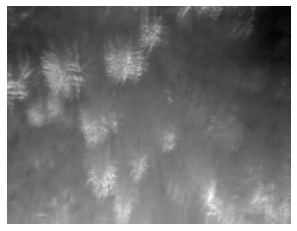

In [19]:
# integrate with undistorted images - borderMode=cv2.BORDER_REPLICATE
image_sequence, integral_image = ids[0]
ids.show_images(image_sequence, figsize=(8, 10))
ids.show_image(integral_image)

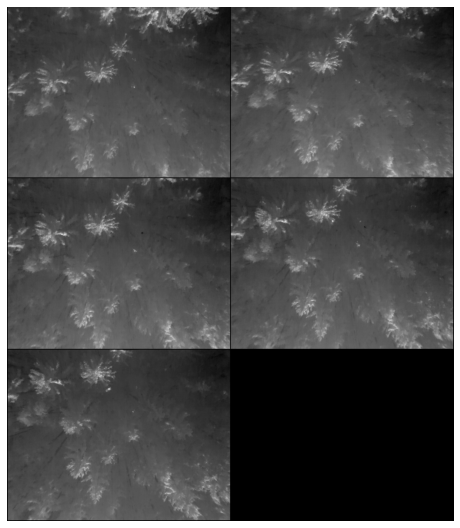

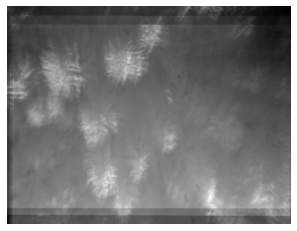

In [14]:
# integrate with undistorted images - undistort v1 - borderMode with constant 0
image_sequence, integral_image = ids[0]
ids.show_images(image_sequence, figsize=(8, 10))
ids.show_image(integral_image)

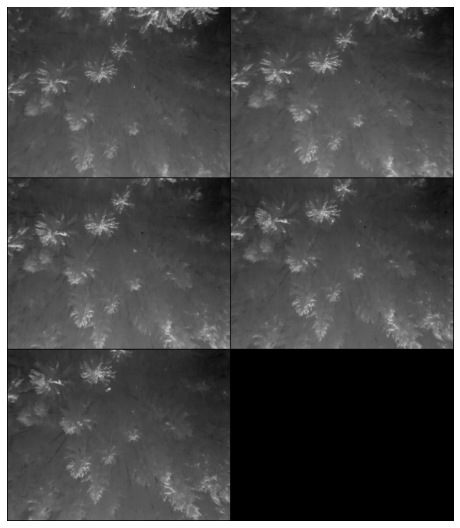

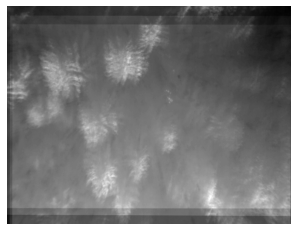

In [10]:
# integrate with undistorted images - undistort v2 - borderMode with constant 0
image_sequence, integral_image = ids[0]
ids.show_images(image_sequence, figsize=(8, 10))
ids.show_image(integral_image)

In [ ]:
# => no difference observed between distortion 